In [1]:
%matplotlib inline
import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import griddata

import ipywidgets as widgets
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import matplotlib.style as style
import matplotlib.patches as patches

from datetime import datetime

Matplotlib settings:

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
style.use('tableau-colorblind10')

Global settings:

In [3]:
date_signature = datetime.now().strftime('%d_%h_%Y')
aperture_name = 'telescope'

# Loading the Data

Load the data: HA (deg), Dec (deg), dome azimuth (deg), $\Delta$HA (the maximum hour angle distance; in hours).

In [4]:
ha, dec, az, delta_ha = np.loadtxt('../../scripts/data/optimal_azimuth_{}_16_Jun_2021.csv'.format(aperture_name), delimiter=',', unpack=True)

hd = np.column_stack([ha, dec])

In [5]:
sel = np.isclose(ha, 177)&np.isclose(dec, 44)
print('(Az, dHA) = ({:.0f} deg, {:.2f} h)'.format(az[sel][0], delta_ha[sel][0]/15))

(Az, dHA) = (182 deg, 2.60 h)


# Visualisation

## Colorplots

In [6]:
ha_range = np.arange(ha.min(), ha.max() + 1, 1)
dec_range = np.arange(dec.min(), dec.max() + 1, 1)

ha_grid, dec_grid = np.meshgrid(ha_range, dec_range, indexing='ij')

Create a $A_d$ grid for imshow from the 1D data...

In [7]:
az_grid = np.zeros(ha_grid.shape) * np.nan

for i in range(0, ha_range.size):
    for j in range(0, dec_range.size):
        h = ha_grid[i, j]
        d = dec_grid[i, j]
        
        sel = np.isclose(ha, h)&np.isclose(dec, d)
        if np.count_nonzero(sel) > 0:
            az_grid[i, j] = az[sel][0]
        else:
            az_grid[i, j] = np.nan

Create a $\Delta h$ grid for imshow from the 1D data...

In [8]:
delta_ha_grid = np.zeros(ha_grid.shape) * np.nan

for i in range(0, ha_range.size):
    for j in range(0, dec_range.size):
        h = ha_grid[i, j]
        d = dec_grid[i, j]
        
        sel = np.isclose(ha, h)&np.isclose(dec, d)
        if np.count_nonzero(sel) > 0:
            delta_ha_grid[i, j] = delta_ha[sel][0]
        else:
            delta_ha_grid[i, j] = np.nan

### Plotting $A_{\text{dome},\text{optimal}}=A_\text{d}\,(h,\delta)$

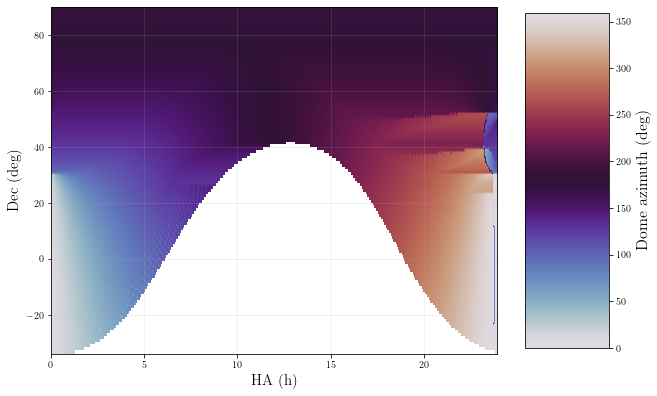

In [9]:
fig = plt.figure(figsize=(10, 8))
frame = fig.add_subplot(1, 1, 1)

frame.set_xlabel('HA (h)', fontsize=15)
frame.set_ylabel('Dec (deg)', fontsize=15)

az_grid_transposed = az_grid.T
az_field = frame.imshow(az_grid_transposed, aspect=0.15, origin='lower', extent=(ha.min()/15, ha.max()/15, dec.min(), dec.max()), 
                        vmin=az.min(), vmax=az.max(), cmap=cm.twilight)

col_bar = fig.colorbar(az_field, shrink=1, aspect=4)
col_bar.set_label('Dome azimuth (deg)', fontsize=16)

frame.grid(alpha=0.2)

plt.show()

fig.savefig('images/{}_optimal_azimuth_{}.png'.format(aperture_name, date_signature), dpi=500)

### Time at each $(h,\delta)$

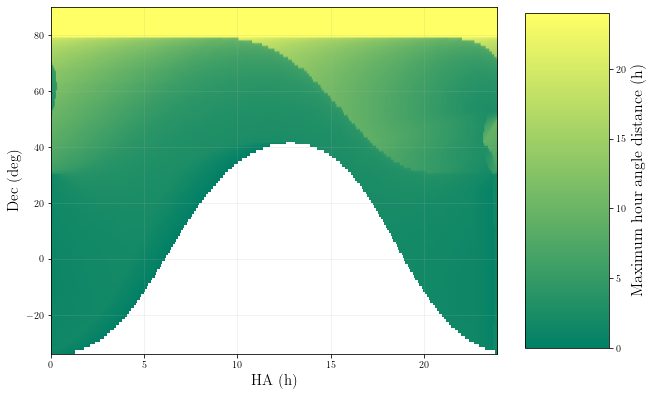

In [10]:
fig = plt.figure(figsize=(10, 8))
frame = fig.add_subplot(1, 1, 1)

frame.set_xlabel('HA (h)', fontsize=15)
frame.set_ylabel('Dec (deg)', fontsize=15)

delta_ha_grid_transposed = delta_ha_grid.T / 15
delta_ha_field = frame.imshow(delta_ha_grid_transposed, aspect=0.15, origin='lower', extent=(ha.min()/15, ha.max()/15, dec.min(), dec.max()), 
                        vmin=delta_ha.min()/15, vmax=delta_ha.max()/15, cmap=cm.summer)

col_bar = fig.colorbar(delta_ha_field, shrink=1, aspect=4)
col_bar.set_label('Maximum hour angle distance (h)', fontsize=16)

frame.grid(alpha=0.2)

plt.show()

fig.savefig('images/{}_max_hour_angle_distance_{}.png'.format(aperture_name, date_signature), dpi=500)

In [11]:
nesw_txt = ['N', 'E', 'S', 'W']
dec_nesw = np.array([36, 0, -36, 0])
ha_nesw  = np.array([12*15, -6*15, 0, 6*15])

In [12]:
def make_polar(h, d):
    r = 90 - d
    x = r * np.cos(np.radians(h)+ 3*np.pi/2)
    y = r * np.sin(np.radians(h)+ 3*np.pi/2)
    
    return x, y

In [13]:
grid_x, grid_y = make_polar(ha_grid, dec_grid)
nesw_x, nesw_y = make_polar(ha_nesw, dec_nesw) # NESW markers
zen_x, zen_y = make_polar(0, 90-53) # Zenith

c_eq_x, c_eq_y = make_polar(ha_range, 0) # Celestial equator
c_36_x, c_36_y = make_polar(ha_range, 36-15) # (Artificial) horizon
cp_36_x, cp_36_y = make_polar(ha_range, 36+15) # circumpolar region

The following plot should probably use a $\log(\Delta\text{HA})$ scale!

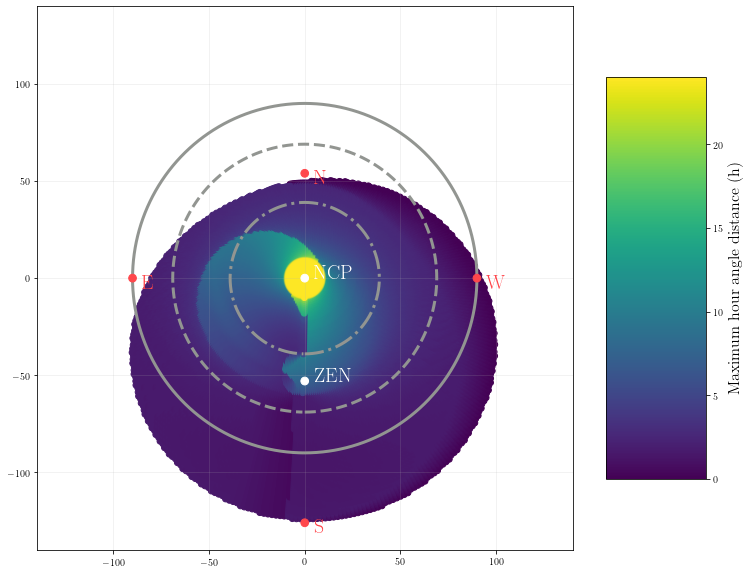

In [14]:
fig = plt.figure(figsize=(12, 10))
frame = fig.add_subplot(1, 1, 1)

cf = frame.scatter(grid_x, grid_y, c=delta_ha_grid/15)
# cf = frame.scatter(grid_x, grid_y, c=np.log10(delta_ha_grid))

col_bar = fig.colorbar(cf, shrink=1, aspect=4)
col_bar.set_label('Maximum hour angle distance (h)', fontsize=16)
# col_bar.set_label('log(Maximum hour angle distance) (h)', fontsize=16)

frame.text(5, 0,'NCP', fontsize=20, fontweight='bold', color='w', zorder=15)
ncp = plt.Circle((0, 0), 2, color='w', zorder=12)
frame.add_patch(ncp)

frame.text(zen_x + 5, zen_y,'ZEN', fontsize=20, fontweight='bold', color='w', zorder=15)
zen = plt.Circle((zen_x, zen_y), 2, color='w', zorder=12)
frame.add_patch(zen)

for x, y, t in zip(nesw_x, nesw_y, nesw_txt):
    frame.text(x + 5, y - 5, t, fontsize=20, fontweight='bold', color='xkcd:light red', zorder=15)
    ncp = plt.Circle((x, y), 2, color='xkcd:light red', zorder=12)
    frame.add_patch(ncp)
    
frame.plot(c_eq_x, c_eq_y, lw=3, ls='-', color='xkcd:grey', zorder=10)
frame.plot(c_36_x, c_36_y, lw=3, ls='--', color='xkcd:grey', zorder=10)
frame.plot(cp_36_x, cp_36_y, lw=3, ls='-.', color='xkcd:grey', zorder=10)

frame.set_xlim(-140, 140)
frame.set_ylim(-140, 140)

frame.grid(alpha=0.2)

plt.show()

fig.savefig('images/{}_max_hour_angle_distance_polar_{}.png'.format(aperture_name, date_signature), dpi=500)

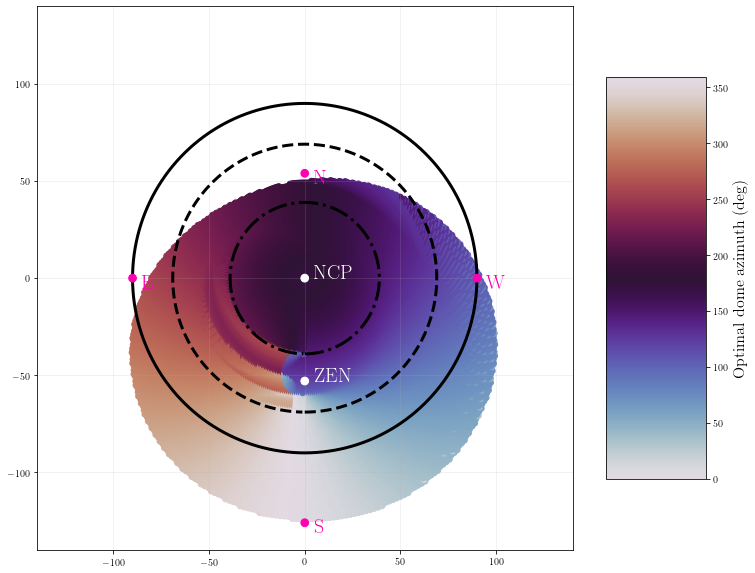

In [15]:
fig = plt.figure(figsize=(12, 10))
frame = fig.add_subplot(1, 1, 1)

cf = frame.scatter(grid_x, grid_y, c=az_grid, cmap=cm.twilight)

col_bar = fig.colorbar(cf, shrink=1, aspect=4)
col_bar.set_label('Optimal dome azimuth (deg)', fontsize=16)

frame.text(5, 0,'NCP', fontsize=20, fontweight='bold', color='w', zorder=15)
ncp = plt.Circle((0, 0), 2, color='w', zorder=12)
frame.add_patch(ncp)

frame.text(zen_x + 5, zen_y,'ZEN', fontsize=20, fontweight='bold', color='w', zorder=15)
zen = plt.Circle((zen_x, zen_y), 2, color='w', zorder=12)
frame.add_patch(zen)

for x, y, t in zip(nesw_x, nesw_y, nesw_txt):
    frame.text(x + 5, y - 5, t, fontsize=20, fontweight='bold', color='xkcd:bright pink', zorder=15)
    ncp = plt.Circle((x, y), 2, color='xkcd:bright pink', zorder=12)
    frame.add_patch(ncp)
    
frame.plot(c_eq_x, c_eq_y, lw=3, ls='-', color='xkcd:black', zorder=10)
frame.plot(c_36_x, c_36_y, lw=3, ls='--', color='xkcd:black', zorder=10)
frame.plot(cp_36_x, cp_36_y, lw=3, ls='-.', color='xkcd:black', zorder=10)

frame.set_xlim(-140, 140)
frame.set_ylim(-140, 140)

frame.grid(alpha=0.2)

plt.show()

fig.savefig('images/{}_dome_azimuth_polar_{}.png'.format(aperture_name, date_signature), dpi=500)

# Where $\Delta A=|A_\text{telescope}-A_\text{dome}|>13\ \text{deg}$

$$\sin(ALT)=\sin(DEC)\sin(LAT)+\cos(DEC)\cos(LAT)\cos(HA)$$

$$\cos(A) = (\sin(\text{DEC}) - \sin(\text{ALT})\sin(\text{LAT}))/(\cos(\text{ALT})\cos(\text{LAT}))$$

In [33]:
def telescope_azimuth(ha, dec):
    phi = np.radians(53.3)
    a = np.radians(6.5)
    
#     y = -np.cos(np.radians(dec)*np.cos(phi)*np.sin(ha))
#     x = np.sin(dec)-np.sin(phi)*np.sin(a)
    
    r = 90-dec
    y = r*np.sin(np.radians(ha))
    
    delta = 90-53.3
    x = r*np.cos(np.radians(ha))-delta
    
    return np.degrees(np.arctan(y, x))

def telescope_azimuth(ha, dec):
    lat = np.radians(53.3)
    alt = np.arcsin(np.sin(dec)*np.sin(lat)+np.cos(dec)*np.cos(lat)*np.cos(ha))
    
    return np.arccos((np.sin(dec)-np.sin(alt)*np.sin(lat))/np.cos(alt)*np.cos(lat))

In [34]:
tele_az = telescope_azimuth(ha_grid, dec_grid)
tele_az[tele_az < 0] = tele_az[tele_az < 0] + 360
tele_az[np.isnan(az_grid)] = np.nan

In [35]:
delta_az = 180 - np.abs(180-np.abs(tele_az - az_grid))

In [36]:
grid_xx = grid_x[~np.isnan(delta_az)]
grid_yy = grid_y[~np.isnan(delta_az)]
delta_azz = delta_az[~np.isnan(delta_az)]

bad = np.where(delta_azz > 13, 1, 0)

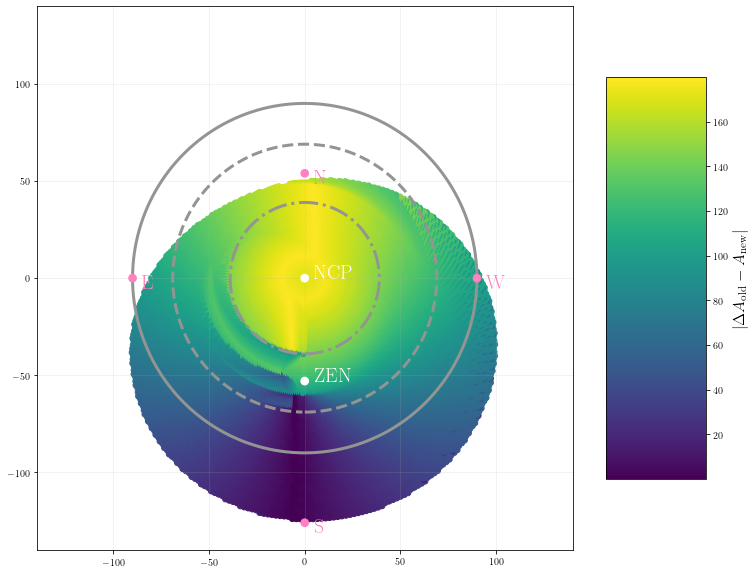

In [37]:
fig = plt.figure(figsize=(12, 10))
frame = fig.add_subplot(1, 1, 1)

cf = frame.scatter(grid_xx, grid_yy, c=delta_azz)

col_bar = fig.colorbar(cf, shrink=1, aspect=4)
col_bar.set_label('$|\Delta A_\mathrm{old}-A_\mathrm{new}|$', fontsize=16)

frame.text(5, 0,'NCP', fontsize=20, fontweight='bold', color='w', zorder=15)
ncp = plt.Circle((0, 0), 2, color='w', zorder=12)
frame.add_patch(ncp)

frame.text(zen_x + 5, zen_y,'ZEN', fontsize=20, fontweight='bold', color='w', zorder=15)
zen = plt.Circle((zen_x, zen_y), 2, color='w', zorder=12)
frame.add_patch(zen)

for x, y, t in zip(nesw_x, nesw_y, nesw_txt):
    frame.text(x + 5, y - 5, t, fontsize=20, fontweight='bold', color='xkcd:pink', zorder=15)
    ncp = plt.Circle((x, y), 2, color='xkcd:pink', zorder=12)
    frame.add_patch(ncp)
    
frame.plot(c_eq_x, c_eq_y, lw=3, ls='-', color='xkcd:grey', zorder=10)
frame.plot(c_36_x, c_36_y, lw=3, ls='--', color='xkcd:grey', zorder=10)
frame.plot(cp_36_x, cp_36_y, lw=3, ls='-.', color='xkcd:grey', zorder=10)

frame.set_xlim(-140, 140)
frame.set_ylim(-140, 140)

frame.grid(alpha=0.2)

# plt.axis('off')
plt.show()

## Polar $(h,\delta)$ plot

In [38]:
compass_color = 'xkcd:light red'
coord_color = 'xkcd:fuchsia'

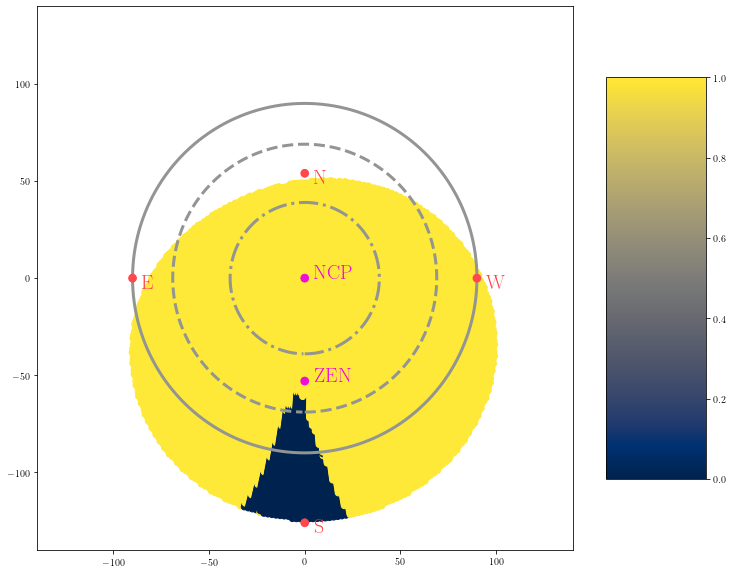

In [39]:
fig = plt.figure(figsize=(12, 10))
frame = fig.add_subplot(1, 1, 1)

cf = frame.scatter(grid_xx, grid_yy, c=bad, cmap=cm.cividis)

col_bar = fig.colorbar(cf, shrink=1, aspect=4)
# col_bar.set_label('', fontsize=16)

frame.text(5, 0,'NCP', fontsize=20, fontweight='bold', color=coord_color, zorder=15)
ncp = plt.Circle((0, 0), 2, color=coord_color, zorder=12)
frame.add_patch(ncp)

frame.text(zen_x + 5, zen_y,'ZEN', fontsize=20, fontweight='bold', color=coord_color, zorder=15)
zen = plt.Circle((zen_x, zen_y), 2, color=coord_color, zorder=12)
frame.add_patch(zen)

for x, y, t in zip(nesw_x, nesw_y, nesw_txt):
    frame.text(x + 5, y - 5, t, fontsize=20, fontweight='bold', color=compass_color, zorder=15)
    ncp = plt.Circle((x, y), 2, color=compass_color, zorder=12)
    frame.add_patch(ncp)
    
frame.plot(c_eq_x, c_eq_y, lw=3, ls='-', color='xkcd:grey', zorder=10)
frame.plot(c_36_x, c_36_y, lw=3, ls='--', color='xkcd:grey', zorder=10)
frame.plot(cp_36_x, cp_36_y, lw=3, ls='-.', color='xkcd:grey', zorder=10)

frame.set_xlim(-140, 140)
frame.set_ylim(-140, 140)

# frame.grid(alpha=0.2)

# plt.axis('off')
plt.show()
fig.savefig('images/{}_good_or_bad_{}.png'.format(aperture_name, date_signature), dpi=500)

## % where $\Delta A < 13\ \text{deg}$

In [32]:
r = bad[bad == 0].size/(bad[bad == 1].size+bad[bad == 0].size)
print('[{}] The new solution is better {:.1%} of the time'.format(aperture_name, 1-r))

[telescope] The new solution is better 91.6% of the time
